In [8]:
import numpy as np
import jax.numpy as jnp
from jax import random, jit
from matplotlib import pyplot as plt
from jaxopt import OptaxSolver
import optax

In [9]:
# Set input dimension
v = 10000

# Set data and target complexity
alpha = 0.6
beta = 0.2

D_vec = jnp.power(jnp.arange(v)+1,-2*alpha)
D = jnp.diag(D_vec)

# Define target
b = jnp.power(jnp.arange(v)+1,-beta)

key = random.key(0)

In [10]:
@jit
def loss(theta,W,data):
    X, y = data
    return jnp.mean((X @ W @ theta - y)**2)

In [11]:
# Sample a batch of size B
def generate_data(B,subkey):
    Z = random.normal(subkey,shape=(B,v))
    X = D_vec * Z
    y = jnp.dot(X,b)

    return X,y

In [12]:
# Approximation of risk / test error
@jit
def risk(theta,W):
    Wtheta = W @ theta
    return jnp.sum(jnp.diag(jnp.outer(Wtheta,Wtheta)) * D_vec) + jnp.sum(D_vec * b**2) - 2 * jnp.sum(jnp.diag(W @ jnp.outer(theta,b)) * D_vec)

In [13]:
def optimize(gamma,B,flops,d,tau,key):
    one = jnp.ones(shape=(d,))
    key, Z_key = random.split(key)
    Z = random.normal(Z_key, shape=(v,d)) / jnp.sqrt(d)
    W = tau / jnp.sqrt(d) * jnp.outer(b,one) + Z    

    r = int(flops / (B*d))
    opt = optax.sgd(learning_rate=gamma)
    solver = OptaxSolver(opt=opt, fun=loss, maxiter=r, jit=True)
    theta = jnp.zeros(d)
    key, subkey = random.split(key)
    data = generate_data(B,subkey)
    state = solver.init_state(theta, W=W, data=data)

    for _ in range(r):
        key, subkey = random.split(key)
        data = generate_data(B,subkey)
        theta, state = solver.update(theta, state, W=W, data=data)

    key, subkey = random.split(key)
    err = risk(theta,W)

    return theta, err

In [14]:
flops = jnp.logspace(4,6,100)
B = 1
gamma = 1e-1
dims = [160]
tau = 0
n_flops = jnp.shape(flops)[0]
n_dims = len(dims)
risks = np.zeros((n_flops,n_dims))

for i, f in enumerate(flops):
    for j, d in enumerate(dims):
        print(f)
        key, subkey = random.split(key)
        theta, err = optimize(gamma,B,f,d,tau,subkey)
        risks[i,j] = err

10000.0
10476.161
10974.982
11497.568
12045.037
12618.575
13219.408
13848.864
14508.293
15199.1045
15922.827
16681.01
17475.275
18307.379
19179.105
20092.338
21049.057
22051.307
23101.303
24201.299
25353.64
26560.854
27825.607
29150.521
30538.557
31992.684
33516.01
35111.953
36783.805
38535.266
40370.164
42292.434
44306.234
46415.87
48626.01
50941.395
53367.023
55908.094
58570.22
61359.1
64280.71
67341.51
70548.05
73907.19
77426.445
81113.1
84975.39
89021.586
93260.34
97701.03
102353.17
107226.72
112332.43
117681.266
123284.65
129154.984
135304.84
141747.38
148496.83
155567.66
162975.0
170735.23
178864.98
187381.83
196304.22
205651.23
215443.31
225702.12
236448.92
247707.97
259502.56
271858.75
284803.62
298364.84
312571.47
327454.9
343047.03
359381.6
376493.94
394420.66
413201.44
432876.47
453487.88
475080.66
497702.16
521401.34
546228.44
572237.06
599484.1
628029.2
657933.5
689260.94
722081.6
756463.5
792483.4
830218.3
869749.1
911163.2
954549.2
1000000.0


Text(0, 0.5, 'Risk')

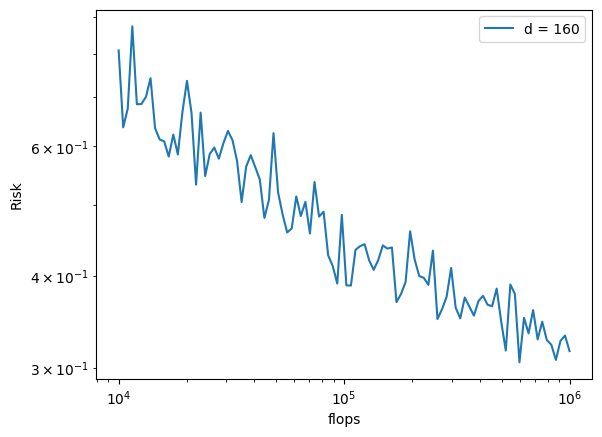

: 

In [15]:
for j,d in enumerate(dims):
    plt.plot(flops,risks[:,j],label="d = {}".format(d))
plt.xscale("log")
plt.yscale("log")
plt.legend()
plt.xlabel("flops")
plt.ylabel("Risk")